In [1]:
%matplotlib inline

from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Activation, Merge
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams, make_sampling_table
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [2]:
text_files = glob('../data/sotu/*.txt')

def text_generator():
    for path in text_files:
        with open(path, 'r') as f:
            yield f.read()
            
len(text_files)

84

In [3]:
# our corpus is small enough where we
# don't need to worry about this, but good practice
max_vocab_size = 50000

# `filters` specify what characters to get rid of
# `base_filter()` includes basic punctuation;
# I like to extend it with common unicode punctuation
tokenizer = Tokenizer(num_words=max_vocab_size,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”–')

# fit the tokenizer
tokenizer.fit_on_texts(text_generator())

# we also want to keep track of the actual vocab size
# we'll need this later
# note: we add one because `0` is a reserved index in keras' tokenizer
vocab_size = len(tokenizer.word_index) + 1

In [4]:
# model (skip-gram)
# two inputs: the target word (also called the "pivot") and the context
# building two separate models for each input and then merge into one

embedding_dim = 256

pivot_model = Sequential()
pivot_model.add(Embedding(vocab_size, embedding_dim, input_length=1))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embedding_dim, input_length=1))

# merge the pivot and context models
model = Sequential()
model.add(Merge([pivot_model, context_model], mode='dot', dot_axes=2))
model.add(Flatten())

# the task as we've framed it here is
# just binary classification,
# so we want the output to be in [0,1],
# and we can use binary crossentropy as our loss
model.add(Activation('sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

/Users/bren/Documents/code/ai-acorns/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app


In [5]:
n_epochs = 10

# used to sample words (indices)
sampling_table = make_sampling_table(vocab_size)

for i in range(n_epochs):
    loss = 0
    for seq in tokenizer.texts_to_sequences_generator(text_generator()):
        # generate skip-gram training examples
        # - `couples` consists of the pivots (i.e. target words) and surrounding contexts
        # - `labels` represent if the context is true or not
        # - `window_size` determines how far to look between words
        # - `negative_samples` specifies the ratio of negative couples
        #    (i.e. couples where the context is false)
        #    to generate with respect to the positive couples;
        #    i.e. `negative_samples=4` means "generate 4 times as many negative samples"
        couples, labels = skipgrams(seq, vocab_size, window_size=5, negative_samples=4, sampling_table=sampling_table)
        if couples:
            pivot, context = zip(*couples)
            pivot = np.array(pivot, dtype='int32')
            context = np.array(context, dtype='int32')
            labels = np.array(labels, dtype='int32')
            loss += model.train_on_batch([pivot, context], labels)
    print('epoch %d, %0.02f'%(i, loss))

epoch 0, 57.95
epoch 1, 47.95
epoch 2, 28.74
epoch 3, 21.79
epoch 4, 19.67
epoch 5, 18.79
epoch 6, 18.44
epoch 7, 18.18
epoch 8, 18.03
epoch 9, 17.92


In [6]:
# extract the embeddings, which are just the weights of the pivot embedding layer
embeddings = model.get_weights()[0][0]

# set aside the tokenizer's word index for later use (and create reverse lookup)
word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in word_index.items()}

In [7]:
# retrieve embedding for a word

def get_embedding(word):
    idx = word_index[word]
    # make it 2d
    return embeddings[idx][:,np.newaxis].T

In [8]:
get_embedding('freedom')

array([[-0.14111687,  0.13135782,  0.09752136, -0.05481698,  0.08899308,
        -0.0831039 ,  0.12113231, -0.10937431,  0.04049063, -0.07060672,
         0.08345166, -0.09675378, -0.04356111, -0.08249366,  0.0731323 ,
        -0.05624429,  0.13478264, -0.1497601 , -0.0766937 , -0.0749528 ,
        -0.04775369, -0.04801683,  0.15229157,  0.05140207,  0.05371787,
        -0.09607103, -0.01106873, -0.05836365, -0.11893501,  0.11818165,
         0.13275471, -0.06224966, -0.08543178,  0.08184115,  0.10630552,
        -0.07782541, -0.10732879, -0.10988855, -0.1364457 , -0.13630675,
         0.05759833, -0.12002464, -0.03082385, -0.0751159 ,  0.1024642 ,
        -0.09654389,  0.0403142 ,  0.06348488,  0.16689961, -0.08083816,
        -0.07809205, -0.12210093, -0.09895474, -0.0158554 , -0.06524352,
         0.05028345, -0.06431597, -0.06774176,  0.13548604, -0.12422658,
         0.02353609, -0.08824867, -0.04785446,  0.08492752, -0.05737381,
         0.15453076,  0.08817381, -0.10913143,  0.0

In [9]:
# given a word, find most similar word

ignore_n_most_common = 50

def get_closest(word):
    embedding = get_embedding(word)

    # get the distance from the embedding
    # to every other embedding
    distances = cdist(embedding, embeddings)[0]

    # pair each embedding index and its distance
    distances = list(enumerate(distances))

    # sort from closest to furthest
    distances = sorted(distances, key=lambda d: d[1])

    # skip the first one; it's the target word
    for idx, dist in distances[1:]:
        # ignore the n most common words;
        # they can get in the way.
        # because the tokenizer organized indices
        # from most common to least, we can just do this
        if idx > ignore_n_most_common:
            return reverse_word_index[idx]

In [10]:
print(get_closest('freedom'))
print(get_closest('justice'))
print(get_closest('america'))
print(get_closest('citizens'))
print(get_closest('citizen'))

those
meeting
find
just
fighting


In [15]:
# above, we computed distances to every other embedding, which is far from
# ideal when dealing with really large vocabularies. Gensim's Word2Vec class
# implements a most_similar method that uses an approximate, but much faster,
# method for finding similar words.

with open('../tsne/embeddings.dat', 'w') as f:
    f.write('{} {}'.format(len(word_index), embedding_dim))

    for word, idx in word_index.items():
        embedding = ' '.join(str(d) for d in embeddings[idx])
        f.write('\n{} {}'.format(word, embedding))

w2v = KeyedVectors.load_word2vec_format('../tsne/embeddings.dat', binary=False)
print(w2v.most_similar(positive=['freedom']))

[('own', 0.9119163751602173), ('goal', 0.9059510231018066), ('firm', 0.9057753682136536), ('great', 0.9037692546844482), ('allies', 0.9023933410644531), ('dignity', 0.9018682241439819), ('stronger', 0.9003569483757019), ('give', 0.9001957178115845), ('better', 0.9000450372695923), ('those', 0.8999913930892944)]


In [16]:
# t-SNE ("t-Distributed Stochastic Neighbor Embedding") is a way of projecting
# high-dimensional data, e.g. our word embeddings, to a lower-dimension
# space, e.g. 2D, so we can visualize it.

# `n_components` is the number of dimensions to reduce to
tsne = TSNE(n_components=2, verbose=2)

# apply the dimensionality reduction
# to our embeddings to get our 2d points
points = tsne.fit_transform(embeddings[:1000])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.137521
[t-SNE] Iteration 25: error = 1.9166362, gradient norm = 0.0147311
[t-SNE] Iteration 50: error = 1.8898010, gradient norm = 0.0145643
[t-SNE] Iteration 75: error = 1.7413851, gradient norm = 0.0107690
[t-SNE] Iteration 100: error = 1.7530107, gradient norm = 0.0116890
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.753011
[t-SNE] Iteration 125: error = 1.6612693, gradient norm = 0.0088131
[t-SNE] Iteration 150: error = 1.7076588, gradient norm = 0.0104173
[t-SNE] Iteration 175: error = 1.7272705, gradient norm = 0.0114900
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 1.753011


In [17]:
print(points[:5])

[[  5.87082879   8.80808147]
 [ -5.96868287  -8.40477869]
 [ -6.42171901  -7.62536066]
 [ -5.17953888 -10.70163027]
 [ -6.37884109 -11.10085894]]


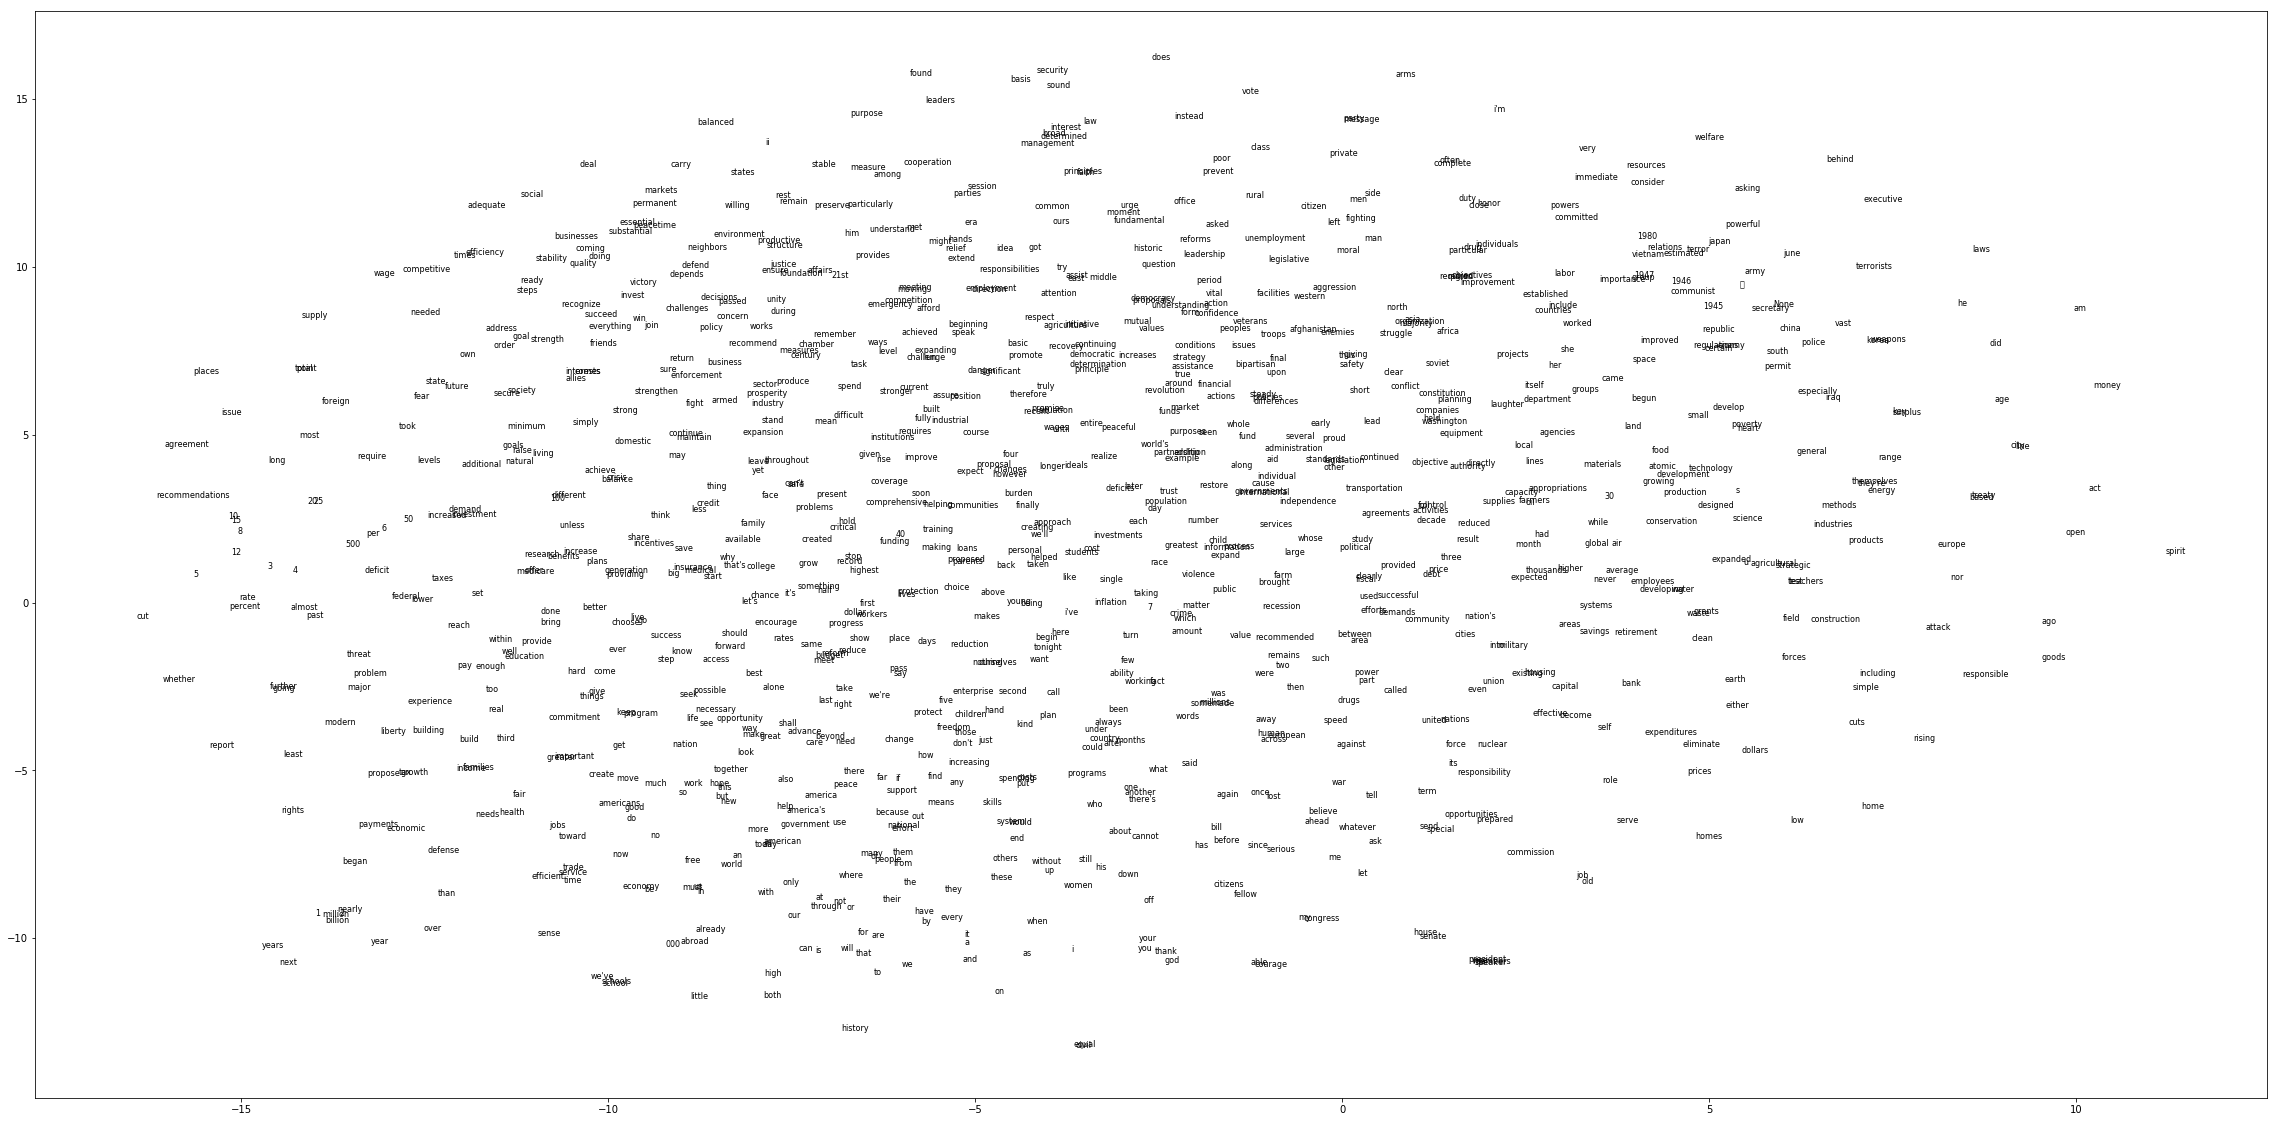

In [18]:
# visualize results

# make it quite big so we can see everything
fig, ax = plt.subplots(figsize=(40, 20))

# extract x and y values separately
xs = points[:,0]
ys = points[:,1]

# plot the points
# we don't actually care about the point markers,
# just want to automatically set the bounds of the plot
ax.scatter(xs, ys, alpha=0)

# annotate each point with its word
for i, point in enumerate(points):
    ax.annotate(reverse_word_index.get(i),
                (xs[i], ys[i]),
                fontsize=8)

plt.savefig('../tsne/tsne.png')